In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
from  scipy import ndimage
IMAGES_FOLDER_PATH = "../img"
import scipy

In [2]:
img3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img3.png'))
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img3_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img3.png'),0)

tri3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'tri3.png'),0)

print(img3.shape)
print(tri3.shape)

(512, 512, 3)
(512, 512)


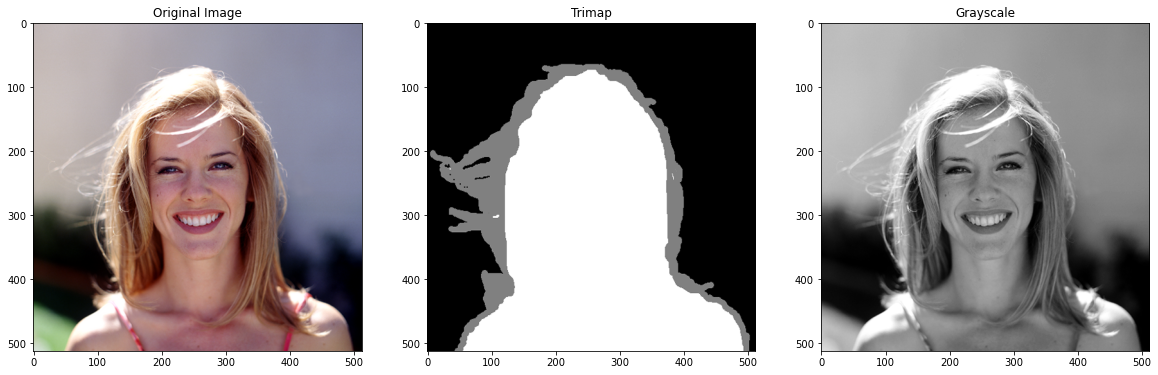

In [3]:
plt.figure(figsize = (20,15))
plt.subplot(131)
plt.imshow(img3)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(tri3,cmap='gray')
plt.title('Trimap')
plt.subplot(133)
plt.imshow(img3_gray,cmap='gray')
plt.title('Grayscale')
plt.show()

(512, 512, 3)


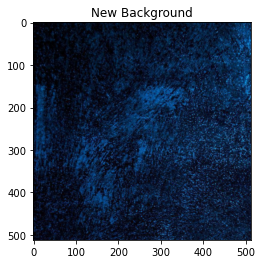

In [4]:
new_bg3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'new_bg3.png'))
new_bg3 = cv2.cvtColor(new_bg3, cv2.COLOR_BGR2RGB)
new_bg3 = new_bg3[:img3.shape[0],:img3.shape[1],:]
print(new_bg3.shape)
plt.imshow(new_bg3)
plt.title('New Background')
plt.show()

# Global Matting

<Figure size 432x288 with 0 Axes>

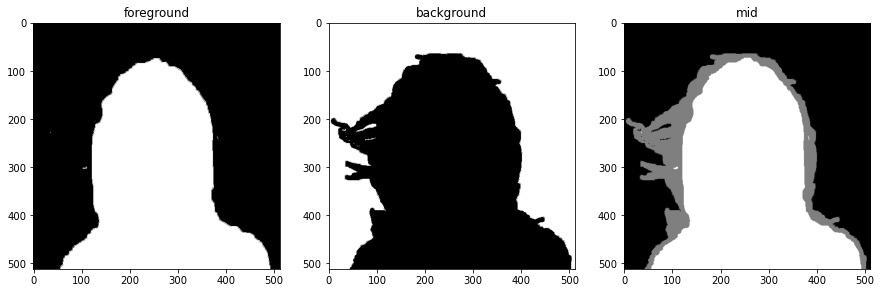

In [5]:
tri = tri3
mid = np.zeros(tri.shape)
foreground = tri == 255
background = tri == 0
rows = mid.shape[0]
cols= mid.shape[1]
for i in range(rows):
    for j in range(cols):
        val = tri[i,j]
        if( val != 0 and val != 255):
            mid[i,j] = 127
            
        if(val != 0 and val > 200):
            mid[i,j] = 255
plt.gray()
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(foreground)
plt.title('foreground')
plt.subplot(132)
plt.imshow(background)
plt.title('background')

plt.subplot(133)
plt.imshow(mid)
plt.title('mid')
plt.show()

Using trimap


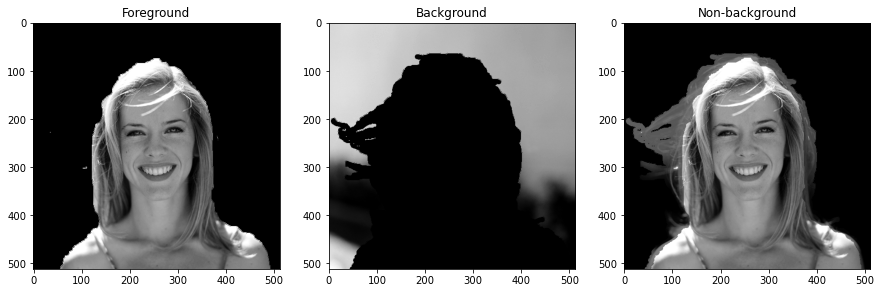

In [6]:
print('Using trimap')
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.gray()
gray_fg = img3_gray * foreground
plt.imshow(gray_fg)
plt.title("Foreground")

gray_bg = img3_gray * background
plt.subplot(132)
plt.imshow(gray_bg,cmap='gray')
plt.title("Background")

non_bg = img3_gray * mid
plt.subplot(133)
plt.imshow(non_bg,cmap='gray')
plt.title("Non-background")
plt.show()

Masks and unknown regions

Text(0.5, 1.0, 'unkown region')

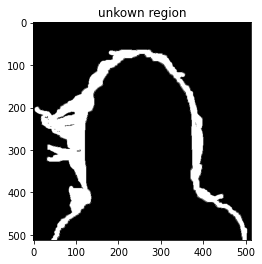

In [7]:

unknown_region =  np.logical_or(foreground,background)
unknown_region = True ^unknown_region
plt.imshow(unknown_region)
plt.title('unkown region')


Estimating Alpha matte using the foreground masks and unknown regions


Text(0.5, 1.0, 'Estimated alpha matte')

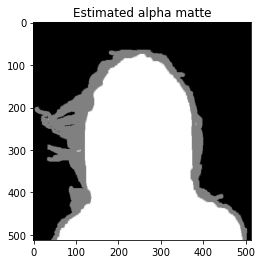

In [8]:
Estimate_alpha = foreground + 0.5 * unknown_region
plt.imshow(Estimate_alpha)
plt.title('Estimated alpha matte')

Inpainting approximate foreground and background images

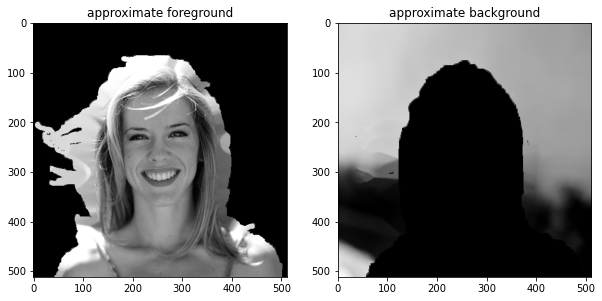

In [9]:
f = (unknown_region + background).astype(np.uint8)*255
apr_foreground = (cv2.inpaint(gray_fg.astype(np.uint8),f,3,cv2.INPAINT_TELEA)).astype(np.float32)
apr_foreground *= np.logical_not(background)
apr_foreground = apr_foreground.astype(np.float32)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(apr_foreground,'gray')
b = (unknown_region + foreground ).astype(np.uint8)*255
apr_background = (cv2.inpaint(gray_bg.astype(np.uint8),b,3,cv2.INPAINT_TELEA)).astype(np.float32) 
apr_background *=  np.logical_not(foreground)
apr_background = apr_background.astype(np.float32) 
plt.title('approximate foreground')
plt.subplot(122)
plt.imshow(apr_background,'gray')
plt.title('approximate background')
plt.show()

Finding the gradient alpha matte 

In [10]:
diff_approx = apr_foreground - apr_background
diff_new = np.minimum(np.maximum(diff_approx,0),255)
diff_approx = scipy.ndimage.filters.gaussian_filter(diff_approx, 0.9)
diff_new = np.minimum(np.maximum(diff_approx,0),255)

dy, dx = np.gradient(img3_gray)
dy = dy/diff_approx
d2y, _ = np.gradient(dy)
dx = dx/diff_approx
_, d2x = np.gradient(dx)
b = d2y + d2x

<ipython-input-10-13f929b65144>:7: RuntimeWarning: invalid value encountered in true_divide
  dy = dy/diff_approx
<ipython-input-10-13f929b65144>:9: RuntimeWarning: invalid value encountered in true_divide
  dx = dx/diff_approx


In [11]:
def get_alpha_matte(alpha, b, max_itrs = 50,thresh = 0.1):
    old_alpha = np.zeros(alpha.shape)
    itrs = 1
    al = alpha - old_alpha
    al = np.abs(al)
    change = np.sum(al)
    while (itrs < max_itrs and change > thresh):
        old_alpha = alpha.copy()
        itrs +=  1
        for i in range(1, alpha.shape[0]-1):
            for j in range(1, alpha.shape[1]-1):
                if(unknown_region[i,j]!=0):
                    temp = alpha[i-1 ,j] + alpha[i,j-1] 
                    temp += old_alpha[i, j+1] + old_alpha[i+1,j]
                    temp -=  b[i,j]
                    alpha[i,j] = 1/4  * temp
        al = alpha - old_alpha
        al = np.abs(al)
        change = np.sum(al)
    return alpha

In [12]:
alpha_new = get_alpha_matte(Estimate_alpha, b)

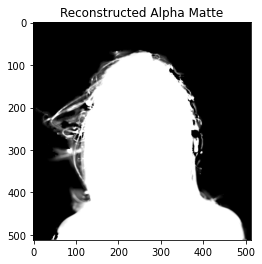

In [13]:
alpha_new = np.minimum(np.maximum(alpha_new,0),1).reshape(img3_gray.shape)
plt.gray()
plt.imshow(alpha_new)
plt.title("Reconstructed Alpha Matte")
plt.show()

## Changing background using alpha blending
I = α F + (1 − α )B

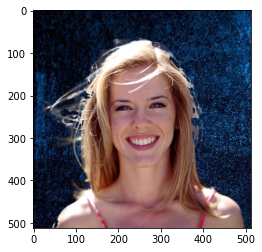

In [14]:
new_img = np.zeros(new_bg3.shape)
new_img[:,:,0] = alpha_new*img3[:,:,0]
new_img[:,:,0] += (1-alpha_new)*new_bg3[:,:,0]
new_img[:,:,1] = alpha_new*img3[:,:,1]
new_img[:,:,1] += (1-alpha_new)*new_bg3[:,:,1]
new_img[:,:,2] = alpha_new*img3[:,:,2]
new_img[:,:,2] += (1-alpha_new)*new_bg3[:,:,2]

plt.imshow(np.int64(new_img),cmap='gray')
plt.show()